In [5]:
import pandas as pd
import numpy as np
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [6]:
# Run the stored data from the Data_Preparation.ipynb
%run ..//Data_Preparation.ipynb


Data types in 'gdp' dataframe:
Time     datetime64[ns]
Value           float64
dtype: object


In [7]:
#We know that gdp is not stationary, so we will take the first difference
gdp['Value_diff'] = gdp['Value'].diff().fillna(0)

#Using the period 1990-2015 for training and 2016-2020 for testing
gdp_train = gdp[(gdp['Time'] >= '1990-01-01') & (gdp['Time'] < '2016-01-01')]

gdp_test = gdp[(gdp['Time'] >= '2016-01-01') & (gdp['Time'] < '2020-01-01')]

#Printing the length of the training and testing data
print("gdp lenght: ", len(gdp_train))
print("gdp lenght: ", len(gdp_test))

gdp lenght:  104
gdp lenght:  16


In [8]:


# Extract the essential variables
endog_train = gdp_train['Value_diff'] # Differenced GDP for training
endog_test = gdp_test['Value_diff'] # Differenced GDP for further training contiously in the one step ahead prediction
endog_train_actuals = gdp_train['Value'] # Actual GDP for training and to normalize the predictions
endog_test_actuals = gdp_test['Value'] # Actual GDP for testing and to normalize the predictions

# Initialize an array to store predictions
y_preds = []

# Define hyperparameters grid for grid search
param_grid = {
    'max_depth': [4, 5, 6],
    'min_child_weight': [5, 10, 15],
    'gamma': [0.5, 1, 1.5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Setting the seed for reproducibility
seed = 42

# Instantiate the XGBoost Regressor model
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', seed=seed)

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)

# Fitting the model
grid_search.fit(np.arange(len(endog_train)).reshape(-1, 1), endog_train)

# Getting the best parameters
best_params = grid_search.best_params_
print("Best parameters found:", best_params)

# Get the best estimator
best_xgb_reg = grid_search.best_estimator_

# Initialize an empty list to store predictions
y_preds = []

# Predict one step ahead for each observation in the test set
for i in range(len(endog_test)):

    
    # Train the model on both train and test data up until the current period
    train_endog = pd.concat([endog_train, endog_test.iloc[:i]], axis=0)
    norm_endog = pd.concat([endog_train_actuals, endog_test_actuals.iloc[:i]], axis=0)
    
    # Fit the model on the updated training data
    best_xgb_reg.fit(np.arange(len(train_endog)).reshape(-1, 1), train_endog)
    
    # Forecast the next period
    forecast_indices = np.arange(len(train_endog), len(train_endog) + 1).reshape(-1, 1)
    y_pred = best_xgb_reg.predict(forecast_indices)

    # Reverse the first difference and cumulative sum to get actual values
    y_pred = y_pred + norm_endog.iloc[-1]

    # Append the prediction to the list
    y_preds.append(y_pred)

# Concatenate predictions into a single numpy array
y_preds = np.concatenate(y_preds)

# Calculating the RMSE
rmse_value = rmse(endog_test_actuals, y_preds)
# Calculating the MAPE
mape_value = mean_absolute_percentage_error(endog_test_actuals, y_preds) * 100  # Multiplying by 100 to get the percentage

print("The RMSE of the model is:", rmse_value)
print("The MAPE of the model is:", mape_value)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters found: {'colsample_bytree': 0.8, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 1.0}
The RMSE of the model is: 22.97910207248272
The MAPE of the model is: 4.032254227504471


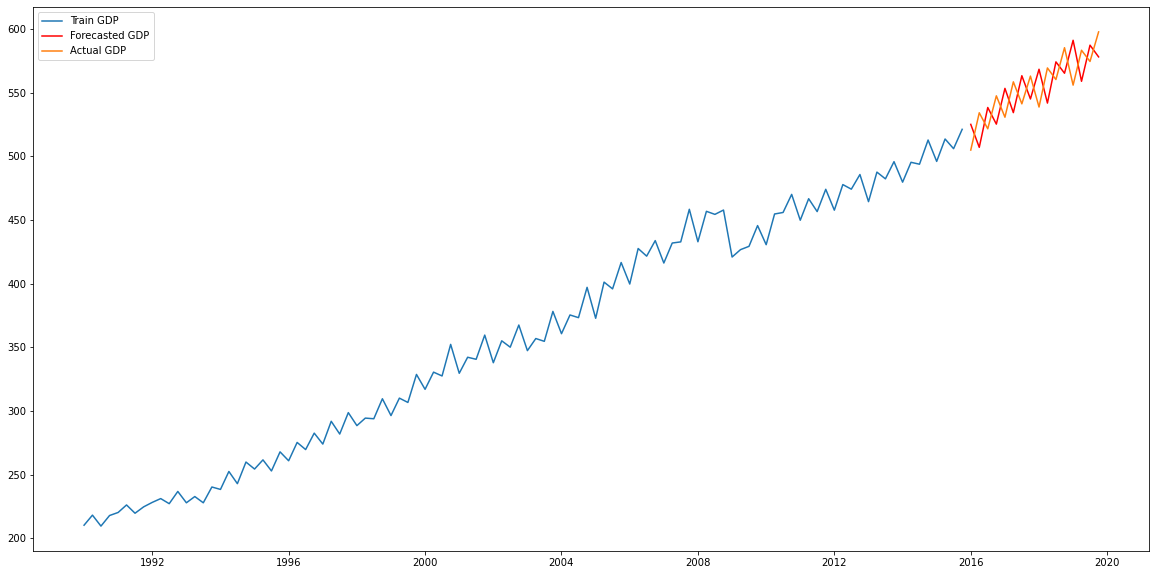

In [9]:
#Plotting the results against the actual values
plt.figure(figsize=(20,10))
plt.plot(gdp_train['Time'].to_numpy(), gdp_train['Value'].to_numpy(), label='Train GDP')
plt.plot(gdp_test['Time'].to_numpy(), y_preds, label='Forecasted GDP', color='red')
plt.plot(gdp_test['Time'].to_numpy(), gdp_test['Value'].to_numpy(), label='Actual GDP')
plt.legend(loc='upper left')
plt.show()

In [10]:
import os
import json

#Define the evaluation metric name for this model
metric_name = "One_UniVar_Pre_GB"

# Create a dictionary with the MAPE value

# Get the current directory
current_dir = os.getcwd()

# Navigate to the directory where mape_values.json is located
json_dir = os.path.abspath(os.path.join(current_dir, '..', '..', '..', 'mape_values.json'))

# Check if the file exists and is not empty
if os.path.exists(json_dir) and os.path.getsize(json_dir) > 0:
    # Load the .json file that stores the MAPE results
    with open(json_dir, 'r') as file:
        data = json.load(file)
else:
    data = {}

# Add the MAPE value to the dictionary with a corresponding key
data[metric_name] = mape_value

# Write the MAPE value to the .json file
with open(json_dir, 'w') as file:
    json.dump(data, file, indent=4)

# Create a dictionary with the RMSE value

# Navigate to the directory where rsme_values.json is located
json_dir = os.path.abspath(os.path.join(current_dir, '..', '..', '..', 'rsme_values.json'))

# Check if the file exists and is not empty
if os.path.exists(json_dir) and os.path.getsize(json_dir) > 0:
    # Load the .json file that stores the RMSE results
    with open(json_dir, 'r') as file:
        data = json.load(file)
else:
    data = {}

# Add the RMSE value to the dictionary with a corresponding key
data[metric_name] = rmse_value

# Write the RMSE value to the .json file
with open(json_dir, 'w') as file:
    json.dump(data, file, indent=4)